# A/B-тестирование

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.<br>

Задача — провести оценку результатов A/B-теста, а именно:
- Оценить корректность проведения теста,
- Проанализировать результаты теста
    
**Цели исследования**
 - Оценить корректность проведения теста, обратить внимание на:
     - Соответствие данных требованиям технического задания, проверим корректность выполнения пунктов технического задания.<br>
     - Время проведения теста, убедимся, что оно не совпадает с маркетинговыми и другими активностями.<br>
     - Аудиторию теста, удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Также проверим равномерность распределения по тестовым группам и правильность их формирования.
    
   <br>

 - Провести исследовательский анализ данных перед A/B-тестированием, ответить на вопросы:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
  
  <br>
    
 - Провести анализ результатов A/B теста и их оценку, проверить статистическую разницу долей z-критерием.

  <br>

 - Сделать общий вывод по исследовательскому анализу данных, проведённой оценке результатов A/B-тестирования, итоговое заключение о корректности проведения теста.

### Знакомство с данными и предобработка

In [1]:
# Импортируем нужные библиотеки для чтения файлов, построения графиков и проведения расчетов

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta
import datetime as dt
from scipy import stats as st
import math as mth
import seaborn as sns
from scipy import stats
from plotly import graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Загрузим файлы
# Календарь маркетинговых событий на 2020 год
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

# Новые пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года
new_users = pd.read_csv('/datasets/final_ab_new_users.csv') 

# Действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
events = pd.read_csv('/datasets/final_ab_events.csv')

# Таблица участников тестов
participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [3]:
# У нас целых 4 датасета, удобно будет сразу создать функцию для просмотра данных
for df in [marketing_events, new_users, events, participants]:
    display(df.info())
    display(df.head(3))
    print('*'*50)
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19


**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC


**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


**************************************************



На первый взгляд в основном всё корректно, даже названия столбцов уже в правильном 'змеином регистре'.<br>

Только в таблице 'events' есть пропуски в столбце 'details' (в нём дополнительные данные о событии, например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах).

Возможно, причина пропусков - отсутствие покупок, да и заполнение этого столбца не обязательно, так как пользователь мог не платить. <br>
Проверим:

In [4]:
# Посчитаем количество всех событий в столбце 'event_name'
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Количество данных по событию 'purchase' ровно такое же, как и количество записей в столбце 'details', а все события в сумме дают нам число 440317 - в датасете именно столько строк.<br>

Оставим пропуски без изменений, можно обойтись и без доп.информации.

Также тип данных в столбцах с датой и временем необходимо скорректировать:

 - столбцы 'start_dt' и 'finish_dt' в таблице marketing_events,
 - столбец 'first_date' в таблице new_users,
 - столбец 'event_dt' в таблице events.

In [5]:
# Скорректируем типы данных
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

# Проверим результат
for df in [marketing_events, new_users, events]:
    print()
    display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


None

Теперь проверка на дубликаты

In [6]:
# Снова создадим функцию
for df in [marketing_events, new_users, events, participants]:
    print('\n Найдено дубликатов в датасете: {}\n'.format(df.duplicated().sum()))


 Найдено дубликатов в датасете: 0


 Найдено дубликатов в датасете: 0


 Найдено дубликатов в датасете: 0


 Найдено дубликатов в датасете: 0



Отлично, дубликатов нет

**Вывод по знакомству с данными и предобработке**

 - Названия столбцов уже были в правильном 'змеином регистре', корректировать не понадобилось.
<br>

 - В таблице 'events' мы нашли пропуски в столбце 'details' (содержащий дополнительные данные о событии).<br>
   Мы выяснили, что возможная причина пропусков - отсутствие покупок, кроме того, заполнение этого столбца не обязательно, так как пользователь мог не платить.<br>
   Решили оставить пропуски без изменений, можно обойтись и без доп.информации.
<br>

- Также тип данных в столбцах с датой и временем необходимо было скорректировать:
  - столбцы 'start_dt' и 'finish_dt' в таблице marketing_events,
  - столбец 'first_date' в таблице new_users,
  - столбец 'event_dt' в таблице events.
<br>


- Дубликаты в 4 датафрймах мы не обнаружили.

### Оценка корректности проведения теста

Проверим проведенный тест на соответствие пунктам технического задания.<br>
Вспомним, как оно звучит:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

#### Время проведения теста
Посмотрим, совпадает ли оно с маркетинговыми и другими активностями.

In [7]:
# Сначала откроем список маркетинговых событий в порядке их проведения  
marketing_events.sort_values(by='start_dt', ascending=True)

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Период, указанный в тех.задании - с 7 декабря 2020 по 4 января 2021 года.<br>
Проверим проведение маркетинговых событий между этими датами.

In [8]:
# Отфильтруем выбранный период
marketing_events_tz = marketing_events[(marketing_events['start_dt']<="2021-01-04") & (marketing_events['finish_dt']>="2020-12-07")]
marketing_events_tz

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


В период нашего А/B теста проводилось 2 маркетинговых события, оба связаны с празднованием нового года:

 - Первое - Christmas&New Year Promo, проводилось 25.12.20 в Европе и Северной Америке
 - Второе - CIS New Year Gift Lottery, 30.12.20 в СНГ

In [9]:
# Теперь выясним сроки действий новых пользователей из таблицы 'events'
print(f"Данные доступны за период: с {events['event_dt'].min()} по {events['event_dt'].max()}")
print(f"Количество дней: {events['event_dt'].max() - events['event_dt'].min()}")

Данные доступны за период: с 2020-12-07 00:00:33 по 2020-12-30 23:36:33
Количество дней: 23 days 23:36:00


Эксперимент должен был продолжаться до 4 января 2021, но мы видим, что сбор данных закончился раньше - 30 декабря 2020.<br>
Скорее всего, недостаток 4х дней связан с новогодними праздниками.<br>

В итоге мы располагаем данными за почти 24 целых дня.

#### Аудитория теста

Сначала проверим пересечение тестовой аудитории с конкурирующим тестом

In [10]:
# Посмотрим количество уникальных записей в столбце 'ab_test'
participants.groupby('ab_test').nunique()

,user_id,group
ab_test,,
interface_eu_test,11567,2
recommender_system_test,6701,2


Видим названия двух тестов, наш тест - только 'recommender_system_test'.<br>

In [11]:
# Проверим пересечения пользователей в обоих тестах
duplicated_users_by_test = participants.groupby('user_id').agg({'ab_test': ['nunique', 'unique']})
duplicated_users_by_test.columns = ['groups', 'group_names']
duplicated_users_by_test = duplicated_users_by_test.query('groups > 1').reset_index()

display(duplicated_users_by_test.head(3))
duplicated_users_by_test.count()

,user_id,groups,group_names
0,001064FEAAB631A1,2,"[recommender_system_test, interface_eu_test]"
1,00341D8401F0F665,2,"[recommender_system_test, interface_eu_test]"
2,003B6786B4FF5B03,2,"[recommender_system_test, interface_eu_test]"


user_id        1602
groups         1602
group_names    1602
dtype: int64

1602 уникальных пользователя участвовали сразу в обоих тестах. Удалять их не станем, чтобы не исказить результаты.<br>

Теперь проверим наличие пользователей, участвующих в двух группах нашего теста 'recommender_system_test' одновременно

In [12]:
duplicated_users_by_group = participants.query('ab_test == "recommender_system_test" ').groupby('user_id').agg({'group': ['nunique', 'unique']})
duplicated_users_by_group.columns = ['groups', 'group_names']
duplicated_users_by_group = duplicated_users_by_group.query('groups > 1')

display(duplicated_users_by_group.head())
len(duplicated_users_by_group)

,groups,group_names
user_id,,


0

Зато между группами А и В нашего теста нет пересечений пользователей.<br>

Теперь создадим новую таблицу, в которой будут только данные по нашему тесту 'recommender_system_test' без 'interface_eu_test'

In [13]:
participants_clean = participants.loc[participants['ab_test'] == "recommender_system_test"]

# Объединим эту очищенную таблицу с участниками и таблицу новых пользователей new_users по общим значениям 'user_id'
participants_and_users = pd.merge(participants_clean, new_users, on = 'user_id')

print(participants_and_users.info())
participants_and_users.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6701 non-null   object        
 1   group       6701 non-null   object        
 2   ab_test     6701 non-null   object        
 3   first_date  6701 non-null   datetime64[ns]
 4   region      6701 non-null   object        
 5   device      6701 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 366.5+ KB
None


,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac


После слияния - 6701 уникальный пользователь.

#### % новых пользователей из региона EU

По тех.заданию должно быть 15%.

In [14]:
# Сгруппируем участников по регионам проведения теста
users_by_region = participants_and_users.groupby('region').agg({'user_id': 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
users_by_region['%_of_all'] = (users_by_region['user_id']*100 / users_by_region['user_id'].sum()).round(2)
users_by_region

,region,user_id,%_of_all
2,EU,6351,94.78
3,N.America,223,3.33
0,APAC,72,1.07
1,CIS,55,0.82


In [15]:
# Посчитаем долю тестируемых пользователей от общего количества пользователей из Европы 
len(participants_and_users.query('region == "EU"')) / len(new_users.query('region == "EU" & first_date <= "2020-12-21"'))*100

15.0

Как раз 15% - соответствует тех.заданию.

#### Дата остановки набора новых пользователей

In [16]:
print(f"Данные доступны за период: с {participants_and_users['first_date'].min()} по {participants_and_users['first_date'].max()}")
print(f"Количество дней набора пользователей: {participants_and_users['first_date'].max() - participants_and_users['first_date'].min()}")

Данные доступны за период: с 2020-12-07 00:00:00 по 2020-12-21 00:00:00
Количество дней набора пользователей: 14 days 00:00:00


По тех.заданию та же дата, 21 декабря 2020 года, это сходится.

#### Равномерность распределения участников по группам

In [17]:
# Сгруппируем участников по группам теста
participants_by_groups = participants_and_users.groupby('group').agg({'user_id': 'nunique'}).reset_index()
participants_by_groups.columns = ['test_group', 'users']
participants_by_groups['%_of_all_users'] = (participants_by_groups['users']*100 / participants_by_groups['users'].sum()).round(2)

participants_by_groups

,test_group,users,%_of_all_users
0,A,3824,57.07
1,B,2877,42.93


Распределение неравномерное, перевес на 7% (почти 1000 участников) в сторону контрольной группы 'A'

#### Воронка событий и конверсия
<a id='shift'></a>

In [18]:
# Сгруппируем уникальных пользователей по событиям
events_funnel = events.groupby('event_name').agg({'user_id':'nunique'}).reset_index()
events_funnel.rename(columns={'user_id': 'events_quantity'}, inplace=True)

events_funnel

,event_name,events_quantity
0,login,58697
1,product_cart,19284
2,product_page,38929
3,purchase,19569


In [19]:
# Посчитаем конверсию между шагами
conversion_step2 = round(38929/58697*100)
conversion_step3 = round(19569/38929*100)

print('% пользователей перешедших на второй этап: {}'.format(conversion_step2))
print('% пользователей перешедших на третий этап: {}'.format(conversion_step3))

% пользователей перешедших на второй этап: 66
% пользователей перешедших на третий этап: 50


Выводы по конверсии:
 - На втором шаге теряется 34% пользователей,
 - Больше всего теряется пользователей на третьем шаге: только 50% пользователей совершают покупку после просмотра страницы с товаром. 
 - На шаге 'purchase' (покупки товара) количество событий больше, чем на стадии 'product_cart' (корзина).<br>
   Странно, но, видимо, есть возможность совершить покупку напрямую без корзины.

#### Вывод по оценке корректности проведения теста

**Время проведения теста**
 - Дата запуска: 2020-12-07, соответствует тех.заданию,
 - Эксперимент должен был продолжаться до 4 января 2021, но сбор данных закончился раньше - 30 декабря 2020,
 - В исследуемый период было проведено 2 маркетинговых события.

**Аудитория теста**
 - В тесте участвуют 6701 пользователей (ожидаемое количество участников 6000),
 - 1602 пользователя участвовали сразу в 2х тестах,
 - Распределение пользователей по тестовым группам не пропорциональное.<br>
   В контрольной группе 'А' 57% пользователей.

**% новых пользователей из региона EU**
 - Совпадает с тех.заданием, 15%.

**Дата остановки набора новых пользователей**
 - Совпадает с тех.заданием, это 21 декабря 2020 года.

### Исследовательский анализ данных

#### События в пределах 14 дней и их количество на пользователя
Сначала ограничим действия, которые произошли в пределах 14 дней, согласно тех.заданию.

In [20]:
# Продолжим объединять таблицы: теперь к 'participants_and_users' добавим 'events'
participants_users_events = pd.merge(participants_and_users, events, on = 'user_id', how='left')

# Добавим столбец с датой события 'event_date' (на основе 'event_dt', но оставим только дату без точного времени события)
participants_users_events['event_date'] = participants_users_events['event_dt'].dt.date
participants_users_events['event_date'] = pd.to_datetime(participants_users_events['event_date'])

# Добавим столбец 'delta': разница в днях между датой регистрации пользователя и совершенным действием
participants_users_events['delta'] = participants_users_events['event_date'] - participants_users_events['first_date']

participants_users_events.head(3)

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,delta
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,0 days
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,18 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,0 days


In [21]:
# Создадим функцию заполнения столбца 'delta' по граничному значению в 14 дней
def timedelta(participants_users_events):
    delta = participants_users_events['event_date'] - participants_users_events['first_date']
    if delta.days <= 14:
        return 'up_to_14'
    else:
        return 'more_than_14'

participants_users_events['delta'] = participants_users_events.apply(timedelta, axis=1)

display(participants_users_events.head(3))
display(participants_users_events['delta'].count())

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date,delta
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,up_to_14
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,more_than_14
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,up_to_14


27724

In [22]:
# Посчитаем, сколько событий попало в обе категории
delta_type = participants_users_events.groupby('delta',as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)
delta_type['%_of_users'] = (delta_type['user_id']*100 / delta_type['user_id'].sum()).round(2)
delta_type

,delta,user_id,%_of_users
1,up_to_14,24070,86.82
0,more_than_14,3654,13.18


<a id='delta14'></a>
Наконец, оставим события, которые укладываются в 14 дней с момента регистрации пользователя

In [23]:
participants_users_events_delta14_ok = participants_users_events.query('delta == "up_to_14"')

# Проверим результат
participants_users_events_delta14_ok['delta'].unique().tolist()

['up_to_14']

Мы избавились от событий, которые произошли в период после 14 дней с момента регистрации пользователя, это 13% от общего числа событий.<br>

Теперь посчитаем количество событий на пользователя.

In [24]:
# Сгруппируем пользователей по тестовым группам и посчитаем среднее количество действий
group_a = participants_users_events_delta14_ok.query('group == "A"')
group_b = participants_users_events_delta14_ok.query('group == "B"')

print('Среднее количество действий на пользователя')
print('Группа А: {:.0f}'.format(group_a.groupby('user_id')['event_name'].count().mean()))
print('Группа В: {:.0f}'.format(group_b.groupby('user_id')['event_name'].count().mean()))

Среднее количество действий на пользователя
Группа А: 7
Группа В: 6


Среднее количество действий на пользователя в контрольной группе А выше, чем в тестовой группе.

#### Как число событий в выборках распределено по дням?

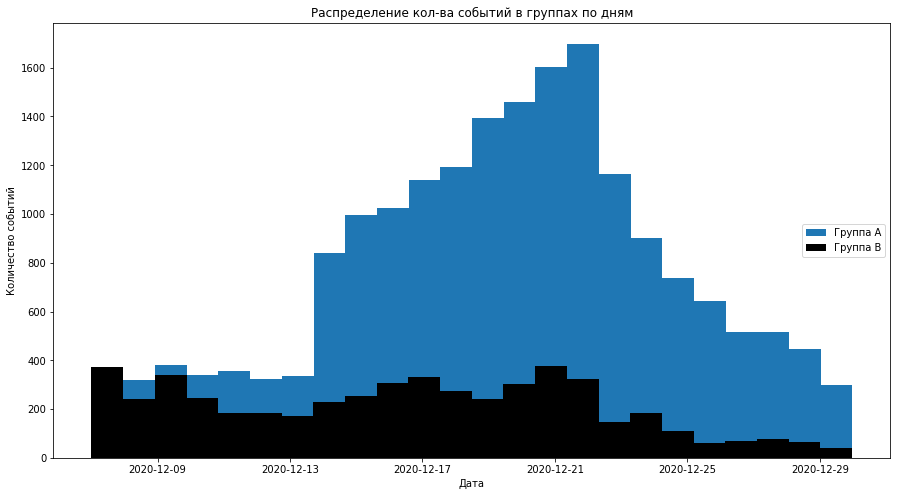

In [25]:
# Отразим распределение кол-ва событий на графике
plt.figure(figsize=(15,8))
plt.hist(participants_users_events_delta14_ok.query('group == "A"')['event_dt'], label='Группа A', bins = 24)
plt.hist(participants_users_events_delta14_ok.query('group == "B"')['event_dt'], label='Группа B', color='k', bins = 24)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Распределение кол-ва событий в группах по дням')
plt.legend(loc='right')
plt.show()

Заметно сильное отличие между группами: тестовая группа В в целом гораздо менее активна.<br>

В отличие от группы В, бросается в глаза рост активности контрольной группы А с 14 по 25 декабря.

#### Как меняется конверсия в воронке в выборках на разных этапах?

Изучим конверсию подробнее, по каждой группе:

In [26]:
# Создадим сводную таблицу с разбивкой по шагам воронки

test_funnel = (
    participants_users_events.pivot_table(
    index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .sort_values(by='A', ascending=False).reindex(['login', 'product_page', 'product_cart', 'purchase']).reset_index(drop=False)
    )

# Добавим сумму пользователей по каждому событию 
test_funnel['total'] = test_funnel.sum(axis=1)

test_funnel

group,event_name,A,B,total
0,login,2747,928,3675
1,product_page,1780,523,2303
2,product_cart,824,255,1079
3,purchase,872,256,1128


In [29]:
# Изобразим воронки
fig = make_subplots(rows=1, cols=2,subplot_titles=("Группа A","Группа B"))

fig.add_trace(go.Funnel(name = 'A', y = test_funnel['event_name'], x = test_funnel['A']), row=1, col=1),
fig.add_trace(go.Funnel(name = 'B', y = test_funnel['event_name'], x = test_funnel['B']), row=1, col=2)

fig.show()

Видим следующее:<br>
От первого шага 'login' до финального 'purchase' добралось только 14% пользователей из группы B и 13% из A.

Показатели конверсии группы В отличаются на каждом этапе воронки.

 - На стадии 'product_page' (экран продукта) конверсия 56% у группы В против 65% в группе А,
 - На стадии 'product_cart' (корзина) коэффициент конверсии составляет 49% у группы В, и 46% у группы А,
 - На стадии 'purchase' (покупка) коэффициент конверсии (относительно стадии 'product_page') группы В составляет 100%, а у группы А 94%.
 
Ожидаемого в группе 'B' улучшения конверсии на 10% не случилось ни на одном из шагов.

Также помним, что количество пользователей на стадии 'purchase' больше, чем на стадии 'product_cart'.<br>
Выглядит странно, но, видимо, есть возможность совершить покупку напрямую без корзины.

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Важные наблюдения:

 - Сбор данных по событиям закончился 30 декабря 2020, поэтому пользователи, пришедшие после 16 декабря не успеют 'прожить' 14 дней, как требуется в тех.задании.
 - Количество участников в группах отличается на 7% (почти 1000 человек), что снижает корректность проведения А/B-теста.
 - Заметная разница в активности между группами: высокая активность контрольной группы А с 14 по 25 декабря, у группы В такого не было,
 - Нетипичная воронка событий: количество пользователей на стадии 'purchase' больше, чем на стадии 'product_cart'.
 - 13% от общего числа событий произошли в период более 14 дней с момента регистрации пользователя.

### Результаты A/B-теста: оценка и анализ

Не все условия тех.задания были выполнены при тестировании:
 - Ожидаемого в группе 'B' улучшения конверсии на 10% не случилось ни на одном из шагов,
 - Дата остановки теста 2020-12-30, что на 4 дня раньше по тех.заданию.

**Проверим статистическую разницу долей z-критерием**

Сформулируем гипотезы:

 - H0: Cтатистически значимых различий в долях между группой A и группой B нет. 
 - H1: Есть статистически значимые различия в долях между группами A и B.

Для удобства создадим функцию с 3 аргументами z_test:
 - group1 - значения 1-ой группы,
 - group2 - значения 2-ой группы, 
 - alpha_value - уровень статистической значимости аlpha.

Критический уровень статистической значимости аlpha выберем = 0.05 и считаем его допустимым.

In [30]:
# Вспомним группировку участников по событиям и А/В группам
test_funnel

group,event_name,A,B,total
0,login,2747,928,3675
1,product_page,1780,523,2303
2,product_cart,824,255,1079
3,purchase,872,256,1128


In [31]:
# Создадим функцию для теста
def z_test(group1, group2, alpha_value):
    alpha = alpha_value
    event_name = test_funnel['event_name']
    
    for i in range(1,len(group1)):
        
        successes = np.array([group1[i], group2[i]])
        trials = np.array([group1[0], group2[0]])
       
        # Пропорция успехов в 1 группе
        p1 = successes[0] / trials[0]  
        # Пропорция успехов во 2 группе
        p2 = successes[1] / trials[1]  
        
        # Пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1]) 
        # Разница пропорций в датасетах
        difference = p1 - p2  
        
        # Посчитаем статистику в стандартных отклонениях
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        
        # Зададим стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
        distr = st.norm(0, 1)  
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        # Воспользуемся поправкой Бонферрони
        bonferroni = alpha / 3
    
        print('Для события "{}" '.format(event_name[i]), end='')
        print('(p-value =', p_value.round(3),'):')
        if (p_value < bonferroni):
            print('Отвергаем нулевую гипотезу: есть статистически значимые различия в долях между группами A и B.')
        else:
            print('Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в долях между группой A и группой B нет.') 
            
        print('')

In [32]:
z_test(test_funnel['A'], test_funnel['B'], 0.05)

Для события "product_page" (p-value = 0.0 ):
Отвергаем нулевую гипотезу: есть статистически значимые различия в долях между группами A и B.

Для события "product_cart" (p-value = 0.145 ):
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в долях между группой A и группой B нет.

Для события "purchase" (p-value = 0.018 ):
Не получилось отвергнуть нулевую гипотезу: статистически значимых различий в долях между группой A и группой B нет.



Статистически значимая разница в группах А и В обнаружена только для события "product_page".<br>

Для остальных событий статистически значимых различий в долях между группой A и группой B не обнаружено.

### Общий вывод по исследовательскому анализу и оценке результатов A/B-тестирования

**Предобработка данных**

 - Мы скорректировали типы данных с датой и временем в соответствующих столбцах датафреймов,
 - В таблице 'events' нашли пропуски в столбце 'details' (содержащий дополнительные данные о событии).<br>
   Решили оставить пропуски без изменений, можно обойтись и без доп.информации.
 - Дубликаты в 4 датафрймах мы не обнаружили.

**Оценка корректности проведения теста**<br>

*Время проведения теста*
 - Дата запуска: 2020-12-07, соответствует тех.заданию,
 - Эксперимент должен был продолжаться до 4 января 2021, но сбор данных закончился раньше - 30 декабря 2020,
 - В исследуемый период было проведено 2 маркетинговых события.

*Аудитория теста*
 - В тесте участвуют 6701 пользователей (ожидаемое количество участников 6000),
 - 1602 пользователя участвовали сразу в 2х тестах,
 - Распределение пользователей по тестовым группам не пропорциональное,<br>
   В отличие контрольной и тестовой групп - 7% (почти 1000 человек), что снижает корректность проведения А/B-теста,
 - % новых пользователей из региона EU Совпадает с тех.заданием: 15%.

*Дата остановки набора новых пользователей*
 - Совпадает с тех.заданием, это 21 декабря 2020 года.

**Исследовательский анализ данных**<br>

*События в пределах 14 дней и их количество на пользователя*
 - 13% от общего числа событий произошли в период более 14 дней с момента регистрации пользователя,
 - Среднее количество действий на пользователя в контрольной группе 'А' выше, чем в тестовой группе,<br>
   Заметно сильное отличие между группами: тестовая группа 'В' в целом гораздо менее активна,<br>
   В отличие от группы 'В', бросается в глаза рост активности контрольной группы А с 14 по 25 декабря.

 - От первого шага 'login' до финального 'purchase' добралось только 14% пользователей из группы B и 13% из A.

*Воронка событий и конверсия*
 - Количество пользователей на стадии 'purchase' больше, чем на стадии 'product_cart': видимо, есть возможность совершить покупку напрямую без корзины,
 - Ожидаемого в тестовой группе 'B' улучшения конверсии на 10% не случилось ни на одном из шагов.
 
**Результаты А/В теста**<br>
Статистически значимая разница в группах А и В обнаружена только для события "product_page".
Для остальных событий статистически значимых различий в долях между группой A и группой B не обнаружено.

В итоге тестовая группа В не показала лучшую конверсию по сравнению с контрольной группой А.<br>
Но у нас есть причины считать проведение теста некорректным.<br>
Рекомендуем провести повторный тест с полным учётом требований технического задания.